In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(10)   
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[0:92469] 
Y_train_SS = Y_train_SS[0:92469]
Y_train_V = Y_train_V[0:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 92469
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 92469 samples, validate on 13210 samples
Epoch 1/100
92096/92469 [============================>.] - ETA: 0s - loss: 0.0260 - dense_5_loss: 0.0163 - dense_6_loss: 0.0098 - dense_5_mse: 0.0163 - dense_6_mse: 0.0098

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.01882, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 12s 128us/sample - loss: 0.0260 - dense_5_loss: 0.0162 - dense_6_loss: 0.0097 - dense_5_mse: 0.0162 - dense_6_mse: 0.0097 - val_loss: 0.0188 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 0.0147 - val_dense_5_mse: 0.0041 - val_dense_6_mse: 0.0147
Epoch 2/100
92128/92469 [============================>.] - ETA: 0s - loss: 0.0124 - dense_5_loss: 0.0035 - dense_6_loss: 0.0088 - dense_5_mse: 0.0035 - dense_6_mse: 0.0088
Epoch 2: val_loss improved from 0.01882 to 0.01329, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 6s 68us/sample - loss: 0.0124 - dense_5_loss: 0.0035 - dense_6_loss: 0.0088 - dense_5_mse: 0.0035 - dense_6_mse: 0.0088 - val_loss: 0.0133 - val_dense_5_loss: 0.0026 - val_dense_6_loss: 0.0107 - val_dense_5_mse: 0.0026 - val_dense_6_mse: 0.0107
Epoch 3/100
91776/92469 [============================>.] - ETA: 0s - loss: 0.0096 - dense_5_loss: 0.0035 - dense_6_loss: 0.0061 - dense_5_mse: 0.0035 - dense_6_mse: 0.0061
Epoch 3: val_loss improved from 0.01329 to 0.00691, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 6s 66us/sample - loss: 0.0096 - dense_5_loss: 0.0035 - dense_6_loss: 0.0061 - dense_5_mse: 0.0035 - dense_6_mse: 0.0061 - val_loss: 0.0069 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0049 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0049
Epoch 4/100
92448/92469 [============================>.] - ETA: 0s - loss: 0.0081 - dense_5_loss: 0.0031 - dense_6_loss: 0.0050 - dense_5_mse: 0.0031 - dense_6_mse: 0.0050
Epoch 4: val_loss improved from 0.00691 to 0.00678, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 7s 72us/sample - loss: 0.0081 - dense_5_loss: 0.0031 - dense_6_loss: 0.0050 - dense_5_mse: 0.0031 - dense_6_mse: 0.0050 - val_loss: 0.0068 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0053 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0053
Epoch 5/100
91712/92469 [============================>.] - ETA: 0s - loss: 0.0072 - dense_5_loss: 0.0029 - dense_6_loss: 0.0043 - dense_5_mse: 0.0029 - dense_6_mse: 0.0043
Epoch 5: val_loss improved from 0.00678 to 0.00660, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 7s 81us/sample - loss: 0.0071 - dense_5_loss: 0.0029 - dense_6_loss: 0.0043 - dense_5_mse: 0.0029 - dense_6_mse: 0.0043 - val_loss: 0.0066 - val_dense_5_loss: 0.0027 - val_dense_6_loss: 0.0039 - val_dense_5_mse: 0.0027 - val_dense_6_mse: 0.0039
Epoch 6/100
91712/92469 [============================>.] - ETA: 0s - loss: 0.0067 - dense_5_loss: 0.0027 - dense_6_loss: 0.0040 - dense_5_mse: 0.0027 - dense_6_mse: 0.0040
Epoch 6: val_loss did not improve from 0.00660
92469/92469 [==============================] - 5s 59us/sample - loss: 0.0067 - dense_5_loss: 0.0027 - dense_6_loss: 0.0040 - dense_5_mse: 0.0027 - dense_6_mse: 0.0040 - val_loss: 0.0070 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0055 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0055
Epoch 7/100
91936/92469 [============================>.] - ETA: 0s - loss: 0.0061 - dense_5_loss: 0.0025 - dense_6_loss: 0.0037 - dense_5_mse: 0.0025 - dense_6_mse: 0.0037
Epoch 7: val_loss did not

92469/92469 [==============================] - 7s 71us/sample - loss: 0.0058 - dense_5_loss: 0.0024 - dense_6_loss: 0.0034 - dense_5_mse: 0.0024 - dense_6_mse: 0.0034 - val_loss: 0.0042 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0026
Epoch 9/100
92352/92469 [============================>.] - ETA: 0s - loss: 0.0050 - dense_5_loss: 0.0020 - dense_6_loss: 0.0030 - dense_5_mse: 0.0020 - dense_6_mse: 0.0030
Epoch 9: val_loss improved from 0.00418 to 0.00411, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 6s 69us/sample - loss: 0.0050 - dense_5_loss: 0.0020 - dense_6_loss: 0.0030 - dense_5_mse: 0.0020 - dense_6_mse: 0.0030 - val_loss: 0.0041 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0028 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0028
Epoch 10/100
92000/92469 [============================>.] - ETA: 0s - loss: 0.0052 - dense_5_loss: 0.0021 - dense_6_loss: 0.0031 - dense_5_mse: 0.0021 - dense_6_mse: 0.0031
Epoch 10: val_loss improved from 0.00411 to 0.00393, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


92469/92469 [==============================] - 6s 69us/sample - loss: 0.0052 - dense_5_loss: 0.0021 - dense_6_loss: 0.0031 - dense_5_mse: 0.0021 - dense_6_mse: 0.0031 - val_loss: 0.0039 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0027
Epoch 11/100
91808/92469 [============================>.] - ETA: 0s - loss: 0.0046 - dense_5_loss: 0.0018 - dense_6_loss: 0.0028 - dense_5_mse: 0.0018 - dense_6_mse: 0.0028
Epoch 11: val_loss did not improve from 0.00393
92469/92469 [==============================] - 5s 57us/sample - loss: 0.0046 - dense_5_loss: 0.0018 - dense_6_loss: 0.0028 - dense_5_mse: 0.0018 - dense_6_mse: 0.0028 - val_loss: 0.0065 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0043 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0043
Epoch 12/100
91648/92469 [============================>.] - ETA: 0s - loss: 0.0046 - dense_5_loss: 0.0019 - dense_6_loss: 0.0027 - dense_5_mse: 0.0019 - dense_6_mse: 0.0027
Epoch 12: val_loss imp

92469/92469 [==============================] - 7s 71us/sample - loss: 0.0046 - dense_5_loss: 0.0019 - dense_6_loss: 0.0027 - dense_5_mse: 0.0019 - dense_6_mse: 0.0027 - val_loss: 0.0036 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0021
Epoch 13/100
92469/92469 [==============================] - ETA: 0s - loss: 0.0046 - dense_5_loss: 0.0018 - dense_6_loss: 0.0028 - dense_5_mse: 0.0018 - dense_6_mse: 0.0028
Epoch 13: val_loss did not improve from 0.00358
92469/92469 [==============================] - 5s 56us/sample - loss: 0.0046 - dense_5_loss: 0.0018 - dense_6_loss: 0.0028 - dense_5_mse: 0.0018 - dense_6_mse: 0.0028 - val_loss: 0.0094 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 0.0058 - val_dense_5_mse: 0.0036 - val_dense_6_mse: 0.0058
Epoch 14/100
91520/92469 [============================>.] - ETA: 0s - loss: 0.0042 - dense_5_loss: 0.0016 - dense_6_loss: 0.0026 - dense_5_mse: 0.0016 - dense_6_mse: 0.0026
Epoch 14: val_loss did

92469/92469 [==============================] - 6s 69us/sample - loss: 0.0042 - dense_5_loss: 0.0017 - dense_6_loss: 0.0025 - dense_5_mse: 0.0017 - dense_6_mse: 0.0025 - val_loss: 0.0031 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0018
Epoch 16/100
92096/92469 [============================>.] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0015 - dense_6_loss: 0.0023 - dense_5_mse: 0.0015 - dense_6_mse: 0.0023
Epoch 16: val_loss did not improve from 0.00311
92469/92469 [==============================] - 5s 56us/sample - loss: 0.0038 - dense_5_loss: 0.0015 - dense_6_loss: 0.0023 - dense_5_mse: 0.0015 - dense_6_mse: 0.0023 - val_loss: 0.0047 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0035 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0035
Epoch 17/100
92128/92469 [============================>.] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0015 - dense_6_loss: 0.0023 - dense_5_mse: 0.0015 - dense_6_mse: 0.0023
Epoch 17: val_loss did

92469/92469 [==============================] - 6s 66us/sample - loss: 0.0034 - dense_5_loss: 0.0013 - dense_6_loss: 0.0021 - dense_5_mse: 0.0013 - dense_6_mse: 0.0021 - val_loss: 0.0030 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0017
Epoch 25/100
92000/92469 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019
Epoch 25: val_loss did not improve from 0.00300
92469/92469 [==============================] - 8s 88us/sample - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019 - val_loss: 0.0039 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0027
Epoch 26/100
92000/92469 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0013 - dense_6_loss: 0.0019 - dense_5_mse: 0.0013 - dense_6_mse: 0.0019
Epoch 26: val_loss did

92469/92469 [==============================] - 9s 101us/sample - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019 - val_loss: 0.0029 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0017
Epoch 28/100
92192/92469 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019
Epoch 28: val_loss did not improve from 0.00289
92469/92469 [==============================] - 5s 55us/sample - loss: 0.0032 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019 - val_loss: 0.0063 - val_dense_5_loss: 0.0019 - val_dense_6_loss: 0.0043 - val_dense_5_mse: 0.0019 - val_dense_6_mse: 0.0043
Epoch 29/100
92416/92469 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018
Epoch 29: val_loss di

92469/92469 [==============================] - 6s 68us/sample - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017 - val_loss: 0.0025 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0014
Epoch 31/100
92192/92469 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018
Epoch 31: val_loss did not improve from 0.00251
92469/92469 [==============================] - 8s 88us/sample - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018 - val_loss: 0.0034 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0018 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0018
Epoch 32/100
92256/92469 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017
Epoch 32: val_loss did

92469/92469 [==============================] - 6s 66us/sample - loss: 0.0027 - dense_5_loss: 0.0010 - dense_6_loss: 0.0016 - dense_5_mse: 0.0010 - dense_6_mse: 0.0016 - val_loss: 0.0024 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0014
Epoch 35/100
92224/92469 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018
Epoch 35: val_loss did not improve from 0.00238
92469/92469 [==============================] - 5s 56us/sample - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_mse: 0.0018 - val_loss: 0.0042 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0030 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0030
Epoch 36/100
92192/92469 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016
Epoch 36: val_loss did

92469/92469 [==============================] - 7s 73us/sample - loss: 0.0021 - dense_5_loss: 8.2474e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.2474e-04 - dense_6_mse: 0.0013 - val_loss: 0.0023 - val_dense_5_loss: 9.8901e-04 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 9.8913e-04 - val_dense_6_mse: 0.0013
Epoch 61/100
92096/92469 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 7.7241e-04 - dense_6_loss: 0.0013 - dense_5_mse: 7.7241e-04 - dense_6_mse: 0.0013
Epoch 61: val_loss did not improve from 0.00226
92469/92469 [==============================] - 8s 89us/sample - loss: 0.0020 - dense_5_loss: 7.7099e-04 - dense_6_loss: 0.0013 - dense_5_mse: 7.7100e-04 - dense_6_mse: 0.0013 - val_loss: 0.0029 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0015
Epoch 62/100
91648/92469 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 7.9302e-04 - dense_6_loss: 0.0012 - dense_5_mse: 7.9302e-04 - de

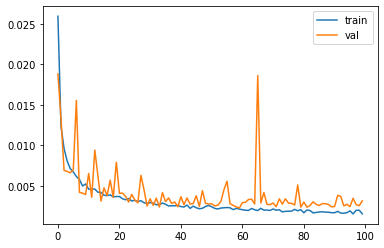

In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]

history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.97357, Train (V) - 0.80369
R2 scores: Validation (SS) - 0.96674, Validation (V) - 0.86592
R2 scores: Testing (SS) - 0.93091, Testing (V) - 0.88562
RMSE scores: Train (SS) - 0.02650, Train (V) - 0.04261
RMSE scores: Validation (SS) - 0.03431, Validation (V) - 0.04431
RMSE scores: Testing (SS) - 0.04845, Testing (V) - 0.03977


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

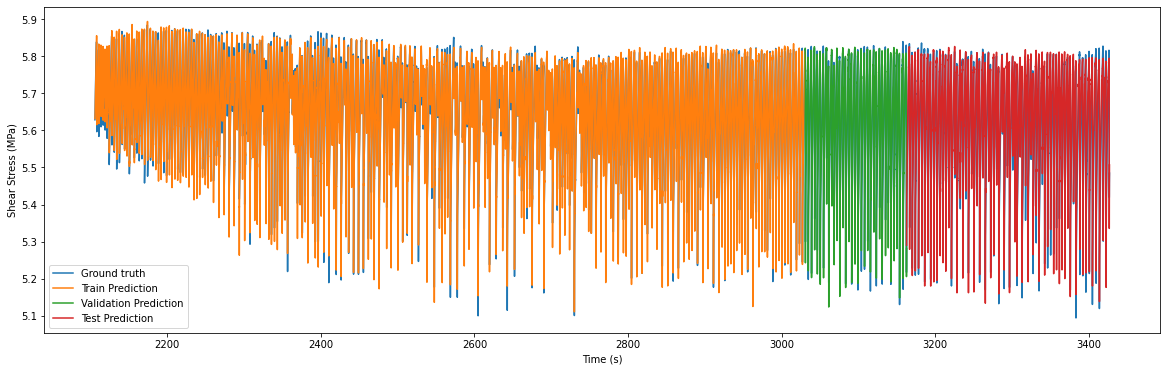

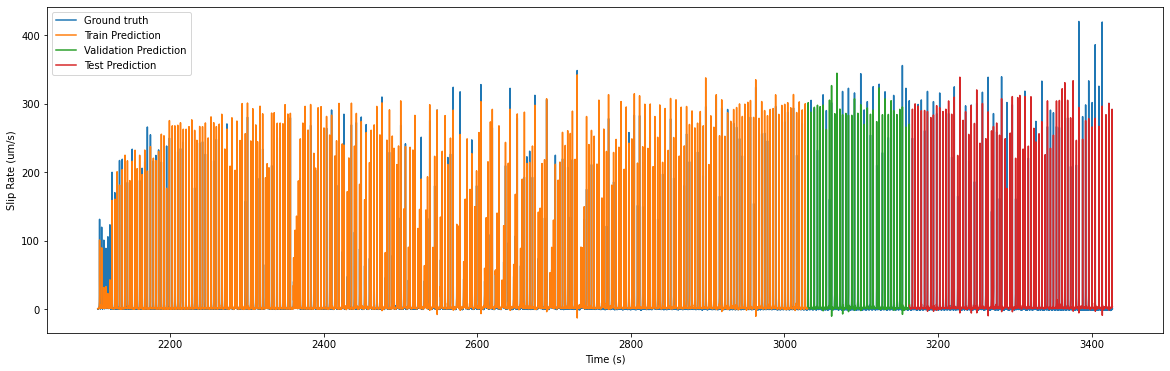

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[0:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

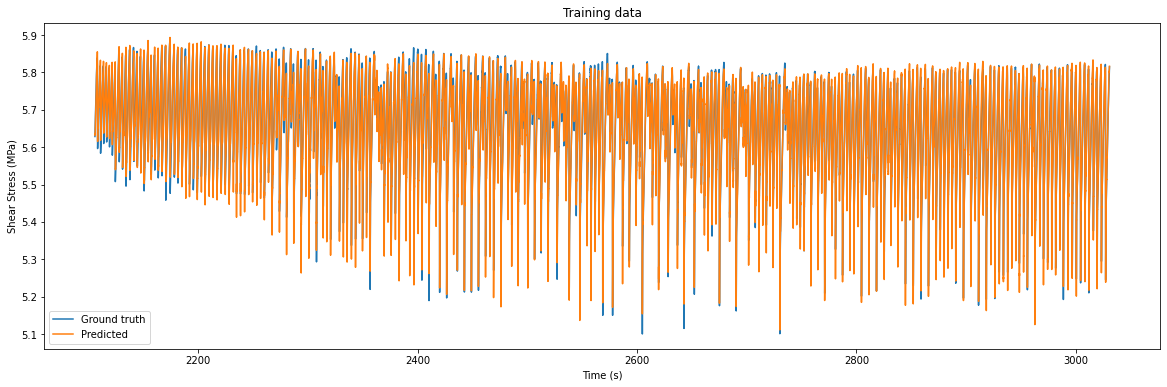

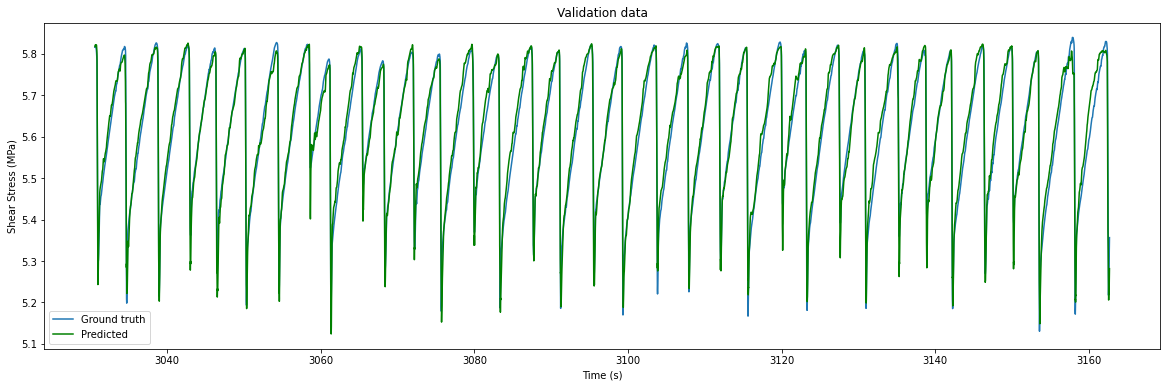

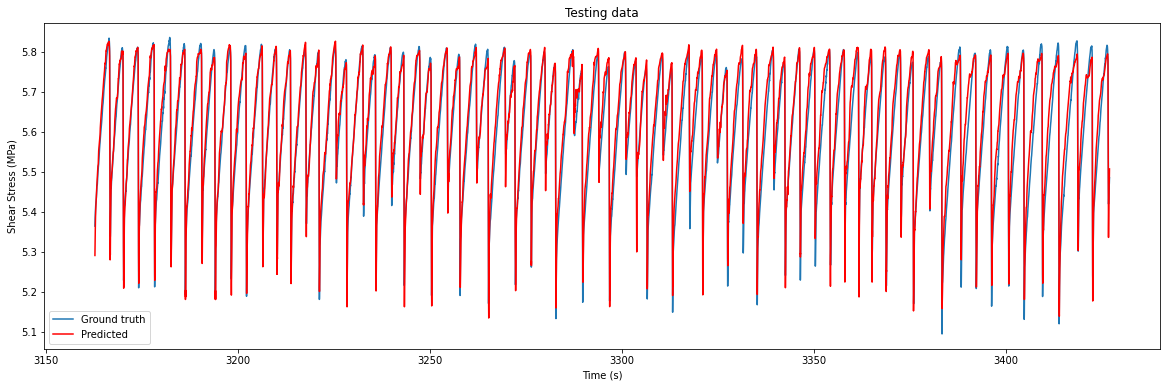

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

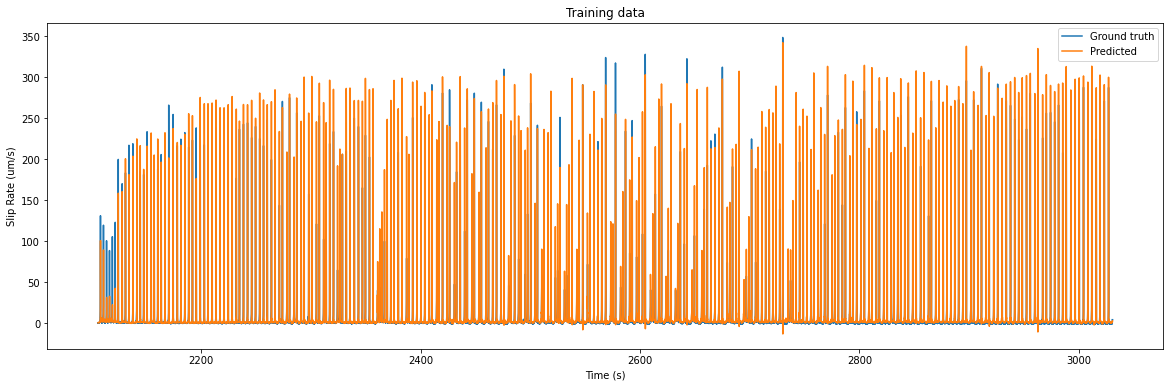

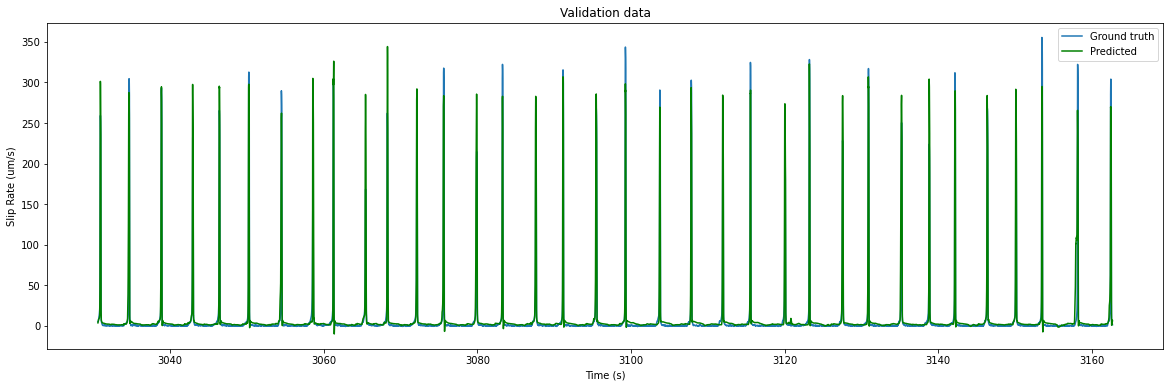

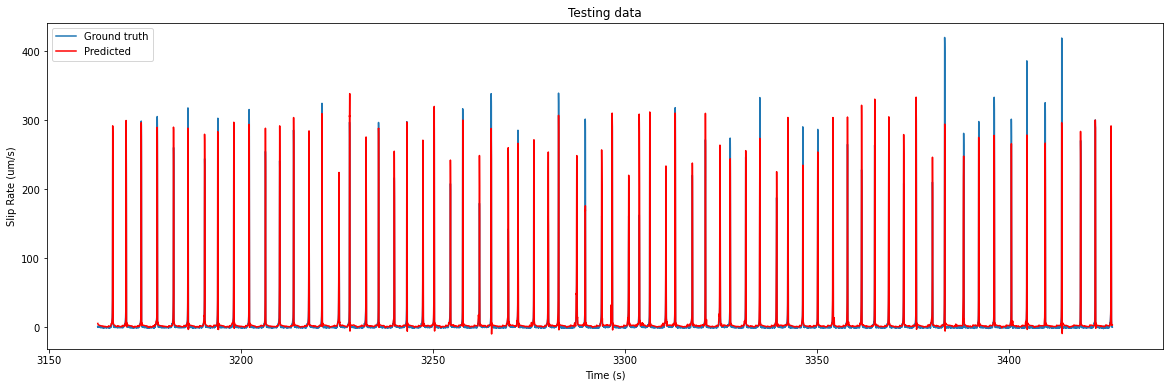

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# Extract Data

# Time 
savetxt('Whole_time.csv', ttime, delimiter=',')
savetxt('traintime.csv', traintime, delimiter=',')
savetxt('valtime.csv', valtime, delimiter=',')
savetxt('testtime.csv', testtime, delimiter=',')

# SS
savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# V
savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
savetxt('y_test_V.csv', y_test_V, delimiter=',')
savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# Download
files.download('Whole_time.csv')
files.download('traintime.csv')
files.download('valtime.csv')
files.download('testtime.csv')

files.download('Y_train_SS.csv')
files.download('Y_val_SS.csv')
files.download('y_test_SS.csv')
files.download('y_predtrain_SS.csv')
files.download('y_predval_SS.csv')
files.download('y_predtest_SS.csv')

files.download('Y_train_V.csv')
files.download('Y_val_V.csv')
files.download('y_test_V.csv')
files.download('y_predtrain_V.csv')
files.download('y_predval_V.csv')
files.download('y_predtest_V.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>